# setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from gg import GG
from utils import read_ds

In [2]:
dir_path = 'data'
datasets = ('australian',
            'banknote',
            'breastcancer',
            'breastHess',
            'bupa',
            'climate',
            'diabetes',
            'fertility',
            'german',
            'golub',
            'haberman',
            'heart',
            'ILPD',
            'parkinsons',
            'sonar')

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# experiment

In [4]:
def run_experiment(eta, tol):
  # params
  epochs = int(np.log(tol) / np.log(1 - eta**2))
  print(eta, tol, epochs)

  # plot
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  axes[0].plot([(1 - eta**2)**(i+1) for i in range(epochs)], c = 'tab:orange');
  axes[0].title.set_text('eta: {}, tol: {}, K: {}'.format(eta, tol, epochs))
  axes[0].set_yscale('log');
  axes[0].set_ylim([1e-3, 1]);
  axes[0].axhline(y = 1e-2, color = 'tab:gray');
  axes[1].plot([(1 - eta**2)**(i+1) for i in range(epochs)], c = 'tab:orange');

  ggclass = GG(device)
  logs = []
  for dataset in tqdm(datasets):
    # read
    X_train, _, X_test, _ = read_ds(dataset, 0, dir_path)
    X = np.concatenate((X_train, X_test), axis = 0)

    # gg
    adj = ggclass.torch(X)

    # bootstrap, hard coded to evaluate each iteration
    N = X.shape[0]
    btsz = int(N * eta)
    idx = np.arange(N)
    adjb = torch.ones((N, N), dtype=torch.bool).to(device)
    log = []

    for epoch in (range(epochs)):
      np.random.shuffle(idx)
      for b in range(0, N, btsz):
        idx_batch = idx[b:min(b+btsz, N)]
        X_batch = X[idx_batch, :]
        adjb[np.ix_(idx_batch, idx_batch)] *= ggclass.torch(X_batch)
      _, count = torch.unique(adj == adjb, return_counts = True)
      log.append(count[0].cpu() / N / N)
    log = log
    axes[0].plot(log, c = 'tab:blue');
    axes[1].plot(log, c = 'tab:blue');
    logs.append(log)
  return logs

# run

0.5 0.01 16


100%|██████████| 15/15 [00:27<00:00,  1.86s/it]


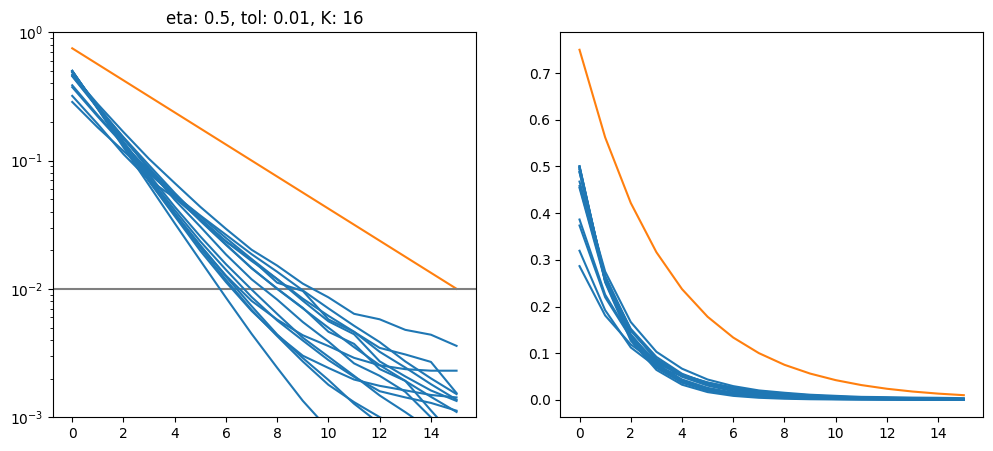

In [5]:
log5 = run_experiment(eta = 0.5, tol = 0.01)

0.1 0.01 458


100%|██████████| 15/15 [11:26<00:00, 45.78s/it]


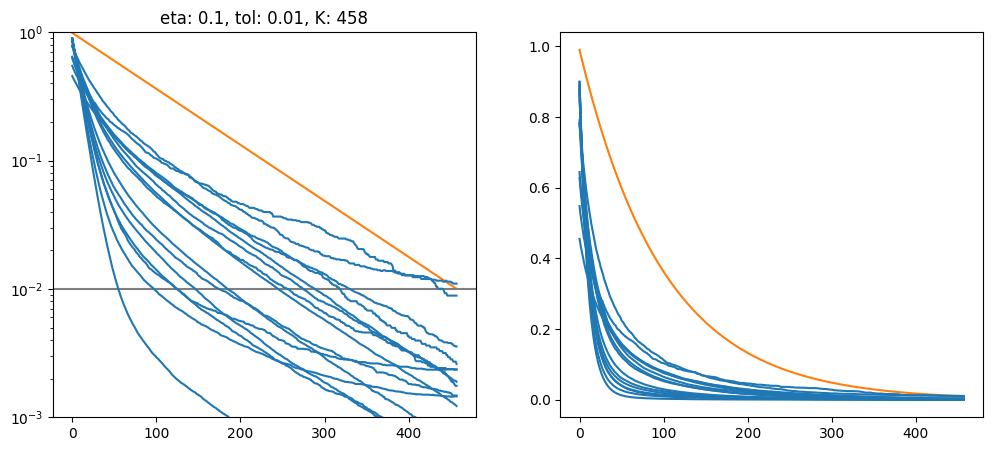

In [6]:
log1 = run_experiment(eta = 0.1, tol = 0.01)